In [9]:

import xml.etree.ElementTree as ET
import networkx as nx
from rich import print
import json
import os
from tqdm import tqdm

def parse_xml_to_graph(xml_data):
    # Parse the XML data
    root = ET.fromstring(xml_data)
    
    # Create a new graph
    G = nx.Graph()

    # Iterate over each vertex in the XML
    for i, vertex in enumerate(root.find('graph').findall('vertex')):
        source = str(i)  # Using the index as the vertex ID, converted to string
        # Iterate over each edge for this vertex
        for edge in vertex.findall('edge'):
            target = edge.text
            cost = float(edge.get('cost'))
            # Add an edge to the graph
            G.add_edge(source, target, weight=cost)

    return G

file = 'brazil58.xml'
# file = 'burma14.xml'

xml_data = open(f'datasets/{file}').read()

# Parse the XML and create the graph
graph = parse_xml_to_graph(xml_data)


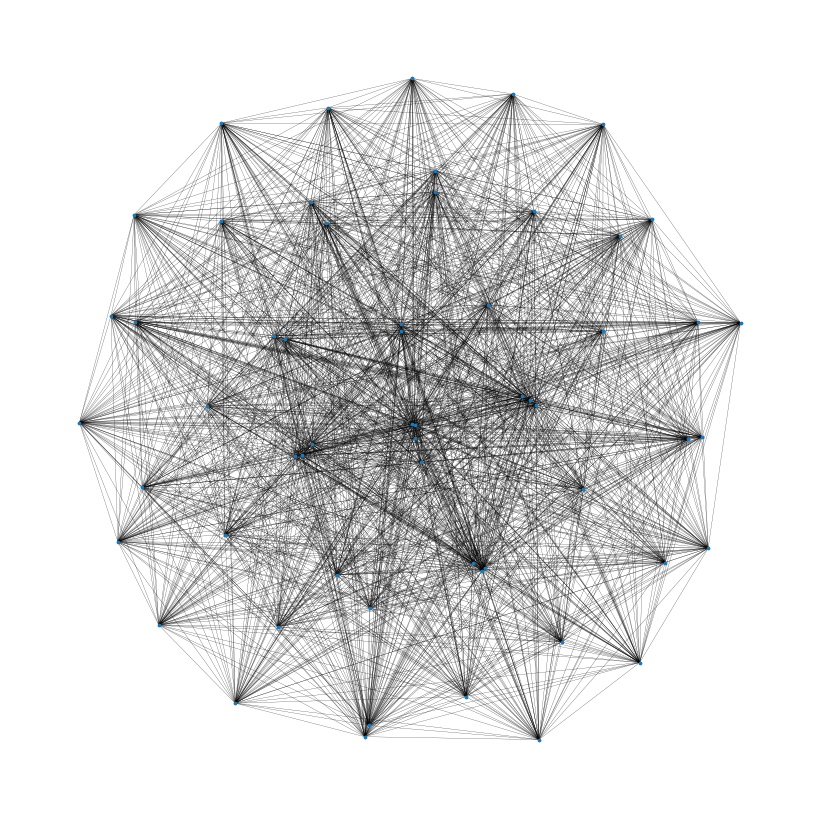

In [10]:
# output the graph using matplotlib
import matplotlib.pyplot as plt
width = 8
plt.figure(figsize=(width, width))
layout = nx.spring_layout(graph, seed=3, k = .5, iterations=2000)
nx.draw(graph, with_labels=False, node_size=3, width=0.15, pos=layout)

In [11]:
import numpy as np

def convert_graph_to_matrix(graph):
    """
    Converts a NetworkX graph into a NumPy matrix.
    Assumes that the graph is complete (i.e., there is an edge between every pair of nodes).

    :param graph: NetworkX graph
    :return: NumPy matrix representing the distances between nodes
    """
    # Create a NumPy matrix of zeros
    n = len(graph.nodes)
    matrix = np.zeros((n, n))

    # Populate the matrix with distances
    for i, node_i in enumerate(graph.nodes):
        for j, node_j in enumerate(graph.nodes):
            if i != j:
                try:
                    # Attempt to get the 'weight' attribute for the edge
                    matrix[i][j] = graph[node_i][node_j]['weight']
                except KeyError:
                    # If the edge does not exist or has no weight, set a large number
                    matrix[i][j] = float('inf')

    return matrix

# Convert the graph into a NumPy matrix
matrix = convert_graph_to_matrix(graph)
print(matrix)

[[   0. 2635. 2713. ... 3870. 1417.  739.]
 [2635.    0.  314. ... 2072. 1196. 1517.]
 [2713.  314.    0. ... 1882. 2699. 1557.]
 ...
 [3870. 2072. 1882. ...    0. 2328. 2986.]
 [1417. 1196. 2699. ... 2328.    0.  962.]
 [ 739. 1517. 1557. ... 2986.  962.    0.]]

In [13]:
import numpy as np
import random

import numpy as np
import random

class AntColonyOptimizer:
    def __init__(self, distance_matrix, num_ants, evaporation_rate, alpha, beta, Q, max_fitness_evaluations, show_progress=False):
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.max_fitness_evaluations = max_fitness_evaluations
        self.num_cities = distance_matrix.shape[0]
        self.show_progress = show_progress

        self.eta = 1.0 / (distance_matrix + np.finfo(float).eps)  # Adding a small epsilon to avoid division by zero
        self.eta[np.eye(self.num_cities, dtype=bool)] = 0  # Set diagonal to zero to avoid self-loop


        # Initialize pheromone levels
        self.pheromone_matrix = np.random.uniform(low=0.1, high=1.0, size=(self.num_cities, self.num_cities))
        self.pheromone_delta = np.zeros_like(self.distance_matrix)

    def run(self):
        best_cost = float('inf')
        best_solution = None
        fitness_evaluations = 0

        start_city = 0  # Initialize start city

        while fitness_evaluations < self.max_fitness_evaluations:
            solutions = []

            for _ in range(self.num_ants):
                solution, cost = self.generate_solution(start_city)
                solutions.append((solution, cost))

                if cost < best_cost:
                    best_cost = cost
                    best_solution = solution

                fitness_evaluations += 1
                if fitness_evaluations >= self.max_fitness_evaluations:
                    break

            self.update_pheromones(solutions)
            self.evaporate_pheromones()

            start_city = (start_city + 1) % self.num_cities  # Change start city for next iteration

        return best_solution, best_cost

    def generate_solution(self, start_city):
        path = [start_city]  # Start at the given city
        visited = set(path)

        while len(path) < self.num_cities:
            next_city = self.select_next_city(path[-1], visited)
            path.append(next_city)
            visited.add(next_city)

        cost = self.calculate_path_cost(path)
        return path, cost


    def select_next_city(self, current_city, visited):
        unvisited_cities = [city for city in range(self.num_cities) if city not in visited]
        probabilities = []

        for city in unvisited_cities:
            tau = self.pheromone_matrix[current_city][city] ** self.alpha
            eta = self.eta[current_city][city] ** self.beta  # Use precomputed eta value
            probabilities.append(tau * eta)

        total = sum(probabilities)
        if total <= 0:
            # Fallback: Choose randomly from remaining unvisited cities
            if unvisited_cities:
                return random.choice(unvisited_cities)
            else:
                raise Exception("No unvisited cities left, but path is incomplete. Check logic.")

        probabilities = [p / total for p in probabilities]  # Normalize probabilities
        next_city = random.choices(unvisited_cities, weights=probabilities, k=1)[0]
        return next_city

    def calculate_path_cost(self, path):
        path_array = np.array(path)
        return np.sum(self.distance_matrix[path_array[:-1], path_array[1:]]) + self.distance_matrix[path[-1], path[0]]


    def update_pheromones(self, solutions):
        self.pheromone_delta.fill(0)  # Reset pheromone_delta matrix to zero

        for solution, cost in solutions:
            for i in range(len(solution) - 1):
                self.pheromone_delta[solution[i], solution[i + 1]] += self.Q / cost

        # Apply the pheromone updates in a vectorized way
        self.pheromone_matrix += self.pheromone_delta

    def evaporate_pheromones(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)

# aco = AntColonyOptimizer(matrix, num_ants=10, evaporation_rate=0.3, alpha=1, beta=2, Q=100, max_fitness_evaluations=10000)
# best_solution, best_cost = aco.run()
# print("Best Solution:", best_solution)
# print("Best Cost:", best_cost)
# 25769.0
# 13.8s
# 26100.0

# # run it with different number of ants
# ant_nums = [10, 20, 50, 100, 200, 500, 1000]

# results = {}

# for ant_num in tqdm(ant_nums, colour='green'):
#     aco = AntColonyOptimizer(matrix, num_ants=ant_num, evaporation_rate=0.3, alpha=1, beta=2, Q=100, max_fitness_evaluations=10000)
#     best_solution, best_cost = aco.run()
#     # print(f"Best Cost for {ant_num} ants:", best_cost)
#     results[ant_num] = best_cost


100%|██████████| 7/7 [01:47<00:00, 15.29s/it]


In [81]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product
from tqdm import tqdm

# ... (your AntColonyOptimizer class code here) ...

def run_aco_with_params(distance_matrix, num_ants, evaporation_rate, alpha, beta):
    aco = AntColonyOptimizer(distance_matrix, num_ants, evaporation_rate, alpha, beta, Q=100, max_fitness_evaluations=10000)
    best_solution, best_cost = aco.run()
    return best_cost, best_solution

def grid_search_aco(distance_matrix, num_ants_options, evaporation_rate_options, alpha_options, beta_options):
    with ProcessPoolExecutor() as executor:
        futures = {}
        for params in product(num_ants_options, evaporation_rate_options, alpha_options, beta_options):
            num_ants, evaporation_rate, alpha, beta = params
            future = executor.submit(run_aco_with_params, distance_matrix, num_ants, evaporation_rate, alpha, beta)
            futures[future] = params

        results = []
        for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating ACO Parameters"):
            result = future.result()
            param_set = futures[future]
            results.append((result, param_set))

    return results

distance_matrix = convert_graph_to_matrix(graph)
num_ants_options = [10, 20, 30, 50, 70, 100]
evaporation_rate_options = [0.1, 0.5, 0.9]
alpha_options = [1, 2, 3]
beta_options = [1, 2, 3]

# Check if there are already results for this dataset
file_name = f'results/results_{file.split(".")[0]}.json'
if os.path.exists(file_name):
    print("Loading best parameter set from file...")
    with open(file_name) as f:
        results = json.load(f)
    
    num_ants, evaporation_rate, alpha, beta = results['best_param_set']
    
    print('Starting ACO with best parameter set...')
    aco = AntColonyOptimizer(matrix, num_ants=num_ants, evaporation_rate=evaporation_rate, alpha=alpha, beta=beta, Q=100, max_fitness_evaluations=10000)
    best_solution, best_cost = aco.run()
    
else:
    results = grid_search_aco(distance_matrix, num_ants_options, evaporation_rate_options, alpha_options, beta_options)
    (best_cost, best_solution), best_param_set = min(results, key=lambda x: x[0][0])
    
    print("Best Result:", best_cost)
    print("Best Parameter Set:", best_param_set)

Evaluating ACO Parameters:   0%|          | 0/162 [00:00<?, ?it/s]

Evaluating ACO Parameters: 100%|██████████| 162/162 [00:33<00:00,  4.79it/s]


Best Result: 3323.0

Best Parameter Set:
(10, 0.1, 1, 2)

In [82]:
# Save the best parameters as a json file if the best result is lower than the previous best result
file_name = f'results/results_{file.split(".")[0]}.json'

# Load the previous best result
if os.path.exists(file_name):
    with open(file_name) as f:
        best_result = json.load(f)
else:
    best_result = {'best_cost': float('inf')}
    
# If the new result is better than the previous best result, save the new result
if best_cost < best_result['best_cost']:
    best_result['best_cost'] = best_cost
    best_result['best_solution'] = best_solution
    best_result['best_param_set'] = best_param_set

    with open(file_name, 'w') as f:
        # save the best result and the parameters used to generate it
        json.dump(best_result, f)
        
        

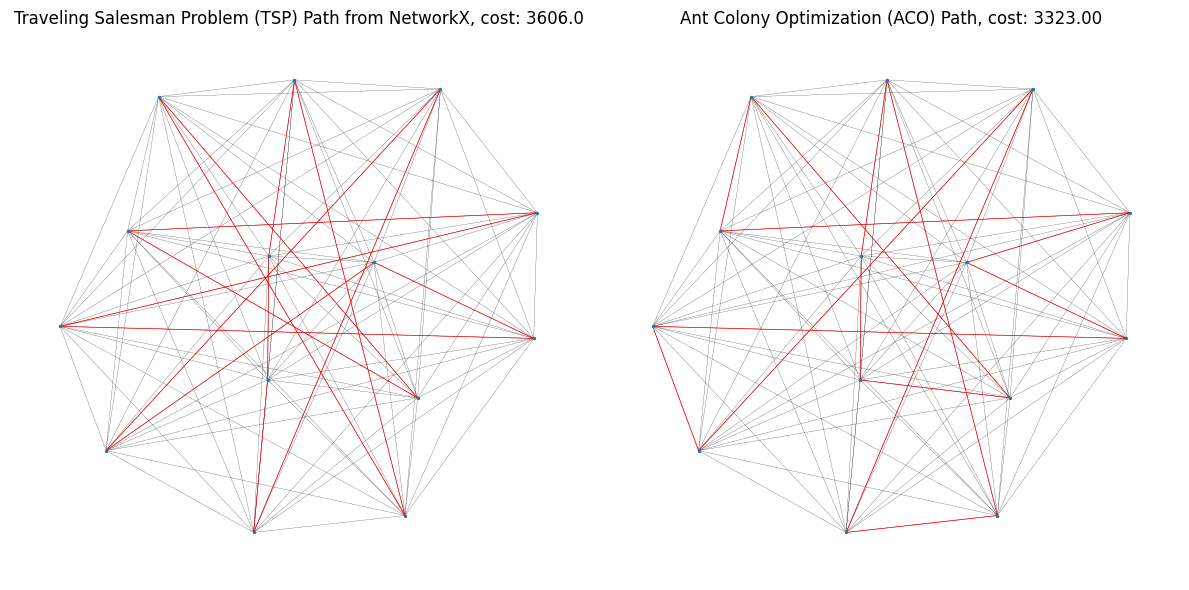

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

# convert the elements of the path to strings
best_solution = [str(x) for x in best_solution]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Extract edges from the ACO path
path_edges = [(best_solution[i], best_solution[i+1]) for i in range(len(best_solution) - 1)]
path_edges.append((best_solution[-1], best_solution[0]))  # Adding edge to complete the tour
# Add the final edge to complete the tour


# Draw TSP path on the left subplot
import networkx.algorithms.approximation as nx_app
cycle = nx_app.christofides(graph, weight="weight")

edge_list = list(nx.utils.pairwise(cycle))
# Combine the two lists into a single networkx graph
tsp_g = nx.Graph()
tsp_g.add_nodes_from(graph.nodes)
tsp_g.add_edges_from(edge_list)

ax1.set_title(f'Traveling Salesman Problem (TSP) Path from NetworkX, cost: {sum(graph[u][v]["weight"] for u, v in edge_list)}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=2, ax=ax1)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.15, ax=ax1)
nx.draw_networkx_edges(tsp_g, pos=layout, width=0.5, edge_color='red', ax=ax1)
ax1.axis('off')

# Draw ACO path on the right subplot
ax2.set_title(f'Ant Colony Optimization (ACO) Path, cost: {best_cost:.2f}')
nx.draw_networkx_nodes(graph, pos=layout, node_size=2, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.15, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=path_edges, width=0.5, edge_color='red', ax=ax2)
ax2.axis('off')



# Adjust layout and display the figure
plt.tight_layout()
# Save the figure
plt.savefig(f'images/aco_path_{file.split(".")[0]}.png', dpi=800)
plt.show()


In [84]:
# Weight of the TSP path found by NetworkX, use the weights of the edges from the original graph
tsp_cost = sum(graph[u][v]['weight'] for u, v in edge_list)
print(f"Cost of TSP Path with NetworkX: {tsp_cost}")


# Weight of the best path found by the ACO algorithm
print(f"Cost of Best Path with ACO: {best_cost}")

Cost of TSP Path with NetworkX: 3606.0

Cost of Best Path with ACO: 3323.0